/var/folders/87/y5h7mytn73s9q6bdthqfk4300000gn/T/ipykernel_74115/3790570263.py:180: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=nodes, y=visits, palette="viridis", ax=axs[1, 1])


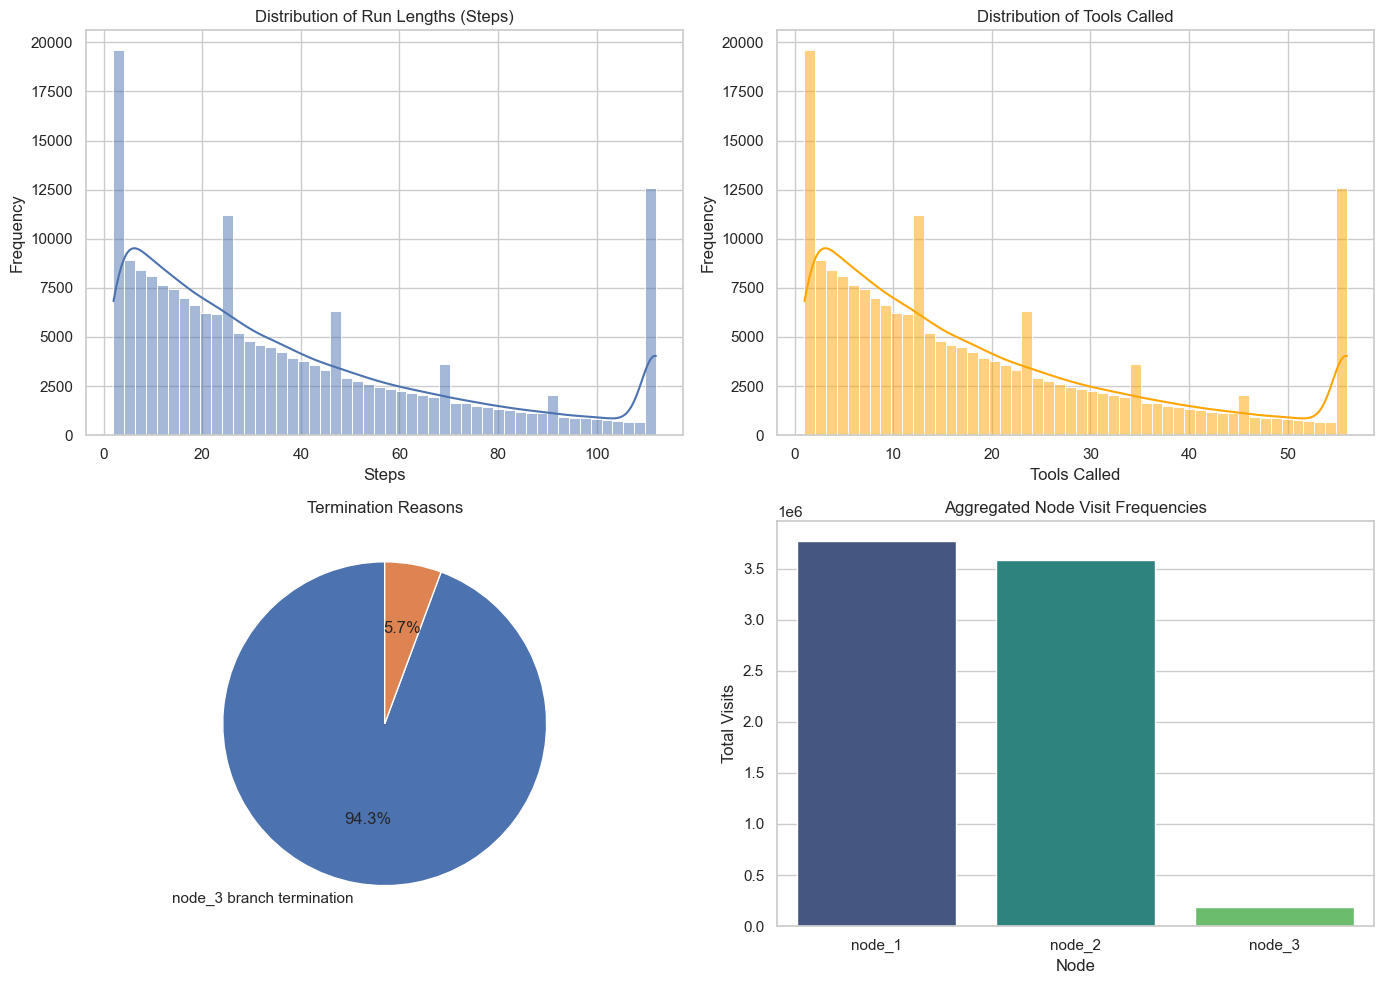

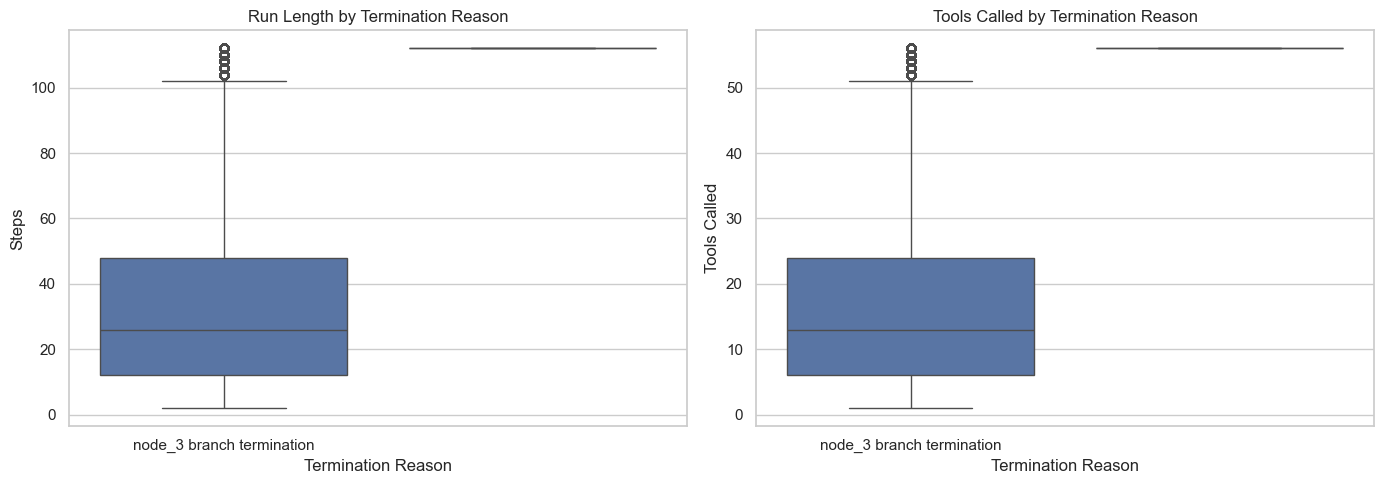

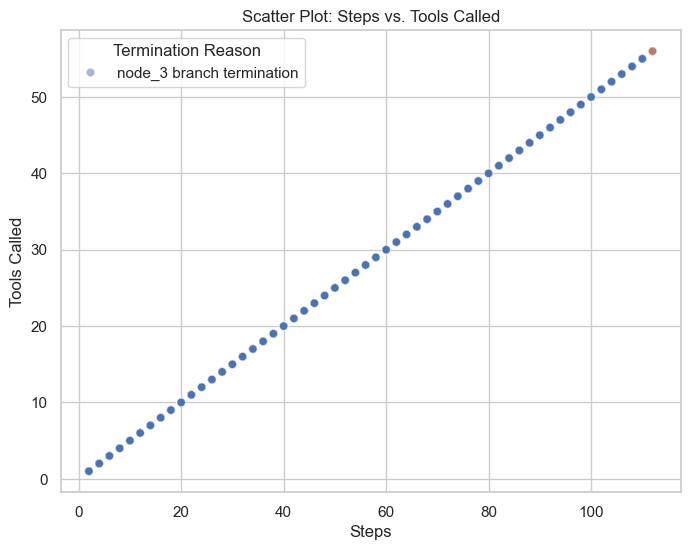

In [3]:
"""
Enhanced LangGraph Simulation and Dashboard

This script updates the state structure to record metrics such as
- Total number of steps,
- Number of visits per node,
- Termination reason.

It then runs 200,000 iterations of the simulation and uses matplotlib
(and optionally seaborn) to visualize the distributions of run lengths,
tools usage, termination reasons, and node visitation frequencies.
"""

import random
from typing import Literal, Dict
from typing_extensions import TypedDict
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Import LangGraph components
from langgraph.graph import StateGraph, START, END

# Update the state data structure to include extra metrics
class TypedDictState(TypedDict):
    # Core state values
    tools_called: int
    name: str
    condition: Literal["good", "bad"]
    # Additional metrics
    steps: int
    node_visits: Dict[str, int]
    termination_reason: str  # Filled in when the simulation terminates

# A helper function to record node visits and steps.
def record_visit(state: TypedDictState, node_name: str):
    state["steps"] += 1
    if node_name in state["node_visits"]:
        state["node_visits"][node_name] += 1
    else:
        state["node_visits"][node_name] = 1

# Node definitions
def node_1(state: TypedDictState):
    record_visit(state, "node_1")
    # Append some text to name as before.
    state["name"] += " -> node_1"
    # Return an updated subset of the state.
    return {
        "name": state["name"],
        "tools_called": state["tools_called"],
        "steps": state["steps"],
        "node_visits": state["node_visits"],
    }

def node_2(state: TypedDictState):
    record_visit(state, "node_2")
    state["tools_called"] += 1
    state["condition"] = "good"
    # Update and return relevant state parts.
    return {
        "condition": state["condition"],
        "tools_called": state["tools_called"],
        "steps": state["steps"],
        "node_visits": state["node_visits"],
    }

def node_3(state: TypedDictState):
    record_visit(state, "node_3")
    state["tools_called"] += 1
    state["condition"] = "bad"
    # Mark termination reason here.
    state["termination_reason"] = "node_3 branch termination"
    return {
        "condition": state["condition"],
        "tools_called": state["tools_called"],
        "steps": state["steps"],
        "node_visits": state["node_visits"],
        "termination_reason": state["termination_reason"],
    }

# Decision functions
def decide_condition(state: TypedDictState) -> Literal["node_2", "node_3"]:
    # With a 95% chance, go to node_2; with a 5% chance, go to node_3.
    if random.random() < 0.95:
        return "node_2"
    return "node_3"

def decide_condition_2(state: TypedDictState):
    # If the tools_called count exceeds 55, terminate.
    if state["tools_called"] > 55:
        state["termination_reason"] = "tools limit exceeded"
        return END
    return "node_1"

# Build and compile the graph
builder = StateGraph(TypedDictState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_condition)
builder.add_conditional_edges("node_2", decide_condition_2)
builder.add_edge("node_3", END)

graph = builder.compile()

# Function to run one simulation and return the final state metrics.
def run_simulation():
    # Initial state setup
    initial_state: TypedDictState = {
        "name": "Hadi",
        "tools_called": 0,
        "condition": "good",  # Default value; may be updated by nodes.
        "steps": 0,
        "node_visits": {},
        "termination_reason": "",  # To be set upon termination.
    }
    # Invoke the graph simulation.
    # Note: If the LangGraph API returns the final state, we capture it.
    final_state = graph.invoke(initial_state, {"recursion_limit": 200})
    return final_state

# Run 200,000 iterations
n_iterations = 200_000

# Prepare lists for storing metrics.
steps_list = []
tools_called_list = []
termination_reasons = []
# For aggregated node visit frequencies.
aggregate_node_visits = {}

# Optionally, record transitions per simulation in a DataFrame.
simulation_records = []

for i in range(n_iterations):
    state = run_simulation()
    steps_list.append(state["steps"])
    tools_called_list.append(state["tools_called"])
    termination_reasons.append(state["termination_reason"])
    simulation_records.append({
        "steps": state["steps"],
        "tools_called": state["tools_called"],
        "termination_reason": state["termination_reason"],
    })
    # Aggregate node visits across all simulations.
    for node, count in state["node_visits"].items():
        aggregate_node_visits[node] = aggregate_node_visits.get(node, 0) + count

# Convert simulation_records to a DataFrame for easier analysis.
df = pd.DataFrame(simulation_records)

# --- Dashboard Visualizations ---
sns.set(style="whitegrid")
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# 1. Distribution of Run Lengths (Steps)
sns.histplot(df["steps"], bins=50, kde=True, ax=axs[0, 0])
axs[0, 0].set_title("Distribution of Run Lengths (Steps)")
axs[0, 0].set_xlabel("Steps")
axs[0, 0].set_ylabel("Frequency")

# 2. Distribution of Tools Called
sns.histplot(df["tools_called"], bins=50, kde=True, color="orange", ax=axs[0, 1])
axs[0, 1].set_title("Distribution of Tools Called")
axs[0, 1].set_xlabel("Tools Called")
axs[0, 1].set_ylabel("Frequency")

# 3. Termination Reason Pie Chart
termination_counts = df["termination_reason"].value_counts()
axs[1, 0].pie(termination_counts, labels=termination_counts.index, autopct="%1.1f%%", startangle=90)
axs[1, 0].set_title("Termination Reasons")

# 4. Aggregated Node Visit Frequencies
nodes = list(aggregate_node_visits.keys())
visits = [aggregate_node_visits[node] for node in nodes]
sns.barplot(x=nodes, y=visits, palette="viridis", ax=axs[1, 1])
axs[1, 1].set_title("Aggregated Node Visit Frequencies")
axs[1, 1].set_xlabel("Node")
axs[1, 1].set_ylabel("Total Visits")

plt.tight_layout()
plt.show()

# --- Additional Visualizations ---

# 5. Boxplots of Steps and Tools Called by Termination Reason
fig2, axs2 = plt.subplots(1, 2, figsize=(14, 5))

sns.boxplot(x="termination_reason", y="steps", data=df, ax=axs2[0])
axs2[0].set_title("Run Length by Termination Reason")
axs2[0].set_xlabel("Termination Reason")
axs2[0].set_ylabel("Steps")

sns.boxplot(x="termination_reason", y="tools_called", data=df, ax=axs2[1])
axs2[1].set_title("Tools Called by Termination Reason")
axs2[1].set_xlabel("Termination Reason")
axs2[1].set_ylabel("Tools Called")

plt.tight_layout()
plt.show()

# 6. Scatter Plot: Steps vs. Tools Called
plt.figure(figsize=(8, 6))
sns.scatterplot(x="steps", y="tools_called", hue="termination_reason", data=df, alpha=0.5)
plt.title("Scatter Plot: Steps vs. Tools Called")
plt.xlabel("Steps")
plt.ylabel("Tools Called")
plt.legend(title="Termination Reason")
plt.show()

# --- End of Dashboard ---


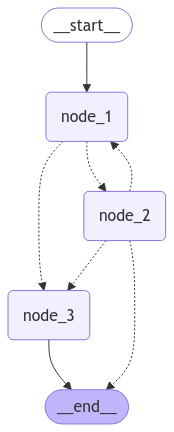

In [4]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod
display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)